## Chapter 17 - Metric Predicted Variable with One Metric Predictor

- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)
- [17.3 - Hierarchical Regression on Individuals within Groups](#17.3---Hierarchical-Regression-on-Individuals-within-Groups)
- [17.4 - Quadratic Trend and Weighted Data](#17.4---Quadratic-Trend-and-Weighted-Data)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from IPython.display import Image
import theano.tensor as tt

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
burnin = 25

f_dict = {'size':16}

In [2]:
# Below function creates plots like 17.3 and 17.4.

def plot_grid(trace, burnin, data, sd_h, sd_w, mean_h, mean_w):
    plt.figure(figsize=(13,13))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h
    beta1 = trace['beta1'][burnin:]*(sd_w/sd_h)
    sigma = trace['sigma'][burnin:]*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
       
    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})

    # Slope
    pm.plot_posterior(beta1, point_estimate='mode', ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    pm.plot_posterior(sigma, point_estimate='mode', ax=ax5, color=color)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    pm.plot_posterior(np.log10(trace['nu'][burnin:]), point_estimate='mode', ax=ax6, color=color)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu'][burnin:]), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    
    return(plt.gcf());

In [3]:
def plot_cred_lines(dist, burnin, x, sd_x, sd_y, mean_x, mean_y, ax):
# Convert parameters to original scale
    beta0 = dist[burnin:,0]*sd_y+mean_y-dist[burnin:,1]*mean_x*sd_y/sd_x
    beta1 = dist[burnin:,1]*(sd_y/sd_x)
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])

    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    hpd_interval = pm.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(x.min()*.95, x.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    

In [4]:
def plot_quad_credlines(dist, burnin, x, sd_x, sd_y, mean_x, mean_y, ax):
# Convert parameters to original scale
    beta0 = dist[burnin:,0]*sd_y+mean_y-dist[burnin:,1]*mean_x*sd_y/sd_x + dist[burnin:,2]*mean_x**2*sd_y/sd_x**2
    beta1 = dist[burnin:,1]*sd_y/sd_x - 2*dist[burnin:,2]*mean_x*sd_y/sd_x**2
    beta2 = dist[burnin:,2]*sd_y/sd_x**2
    B = pd.DataFrame(np.c_[beta0, beta1, beta2], columns=['beta0', 'beta1', 'beta2'])

    # Credible regression lines from posterior
    hpd_interval = pm.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:]) & B.beta2.between(*hpd_interval[2,:])] 
    xrange = np.arange(x.min()-1, x.max()+2)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange+B_hpd.iloc[i,2]*xrange**2, c=color, alpha=.6, zorder=0)    

### 17.2 - Robust Linear Regression

#### Model (Kruschke, 2015)

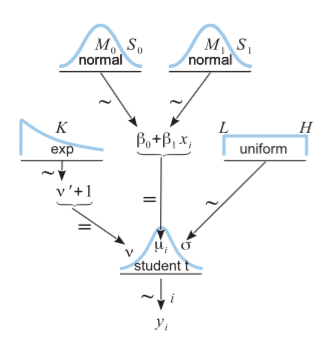

In [5]:
Image('images/fig17_2.png', width=400)

#### N = 30

In [6]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
male      30 non-null int64
height    30 non-null float64
weight    30 non-null float64
dtypes: float64(2), int64(1)
memory usage: 800.0 bytes


In [7]:
df_n30.head()

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6
3,0,64.2,117.3
4,0,64.8,123.3


In [8]:
sd_h = df_n30.height.std()
mean_h = df_n30.height.mean()
zheight = (df_n30.height - mean_h)/sd_h

sd_w = df_n30.weight.std()
mean_w = df_n30.weight.mean()
zy = (df_n30.weight - mean_w)/sd_w

#### Model

In [9]:
with pm.Model() as model:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight.ravel()
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy.ravel())

In [10]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 53.535:  76%|███████▌  | 151235/200000 [00:18<00:05, 8350.66it/s]
Convergence archived at 152000
Interrupted at 152,000 [76%]: Average Loss = 57.836
100%|██████████| 10500/10500 [00:12<00:00, 808.03it/s]


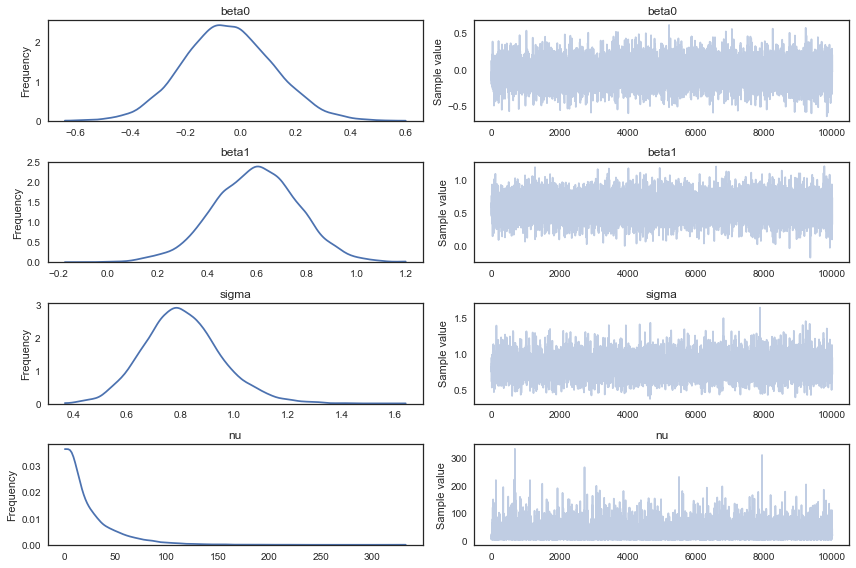

In [11]:
pm.traceplot(trace);

#### Figure 17.3

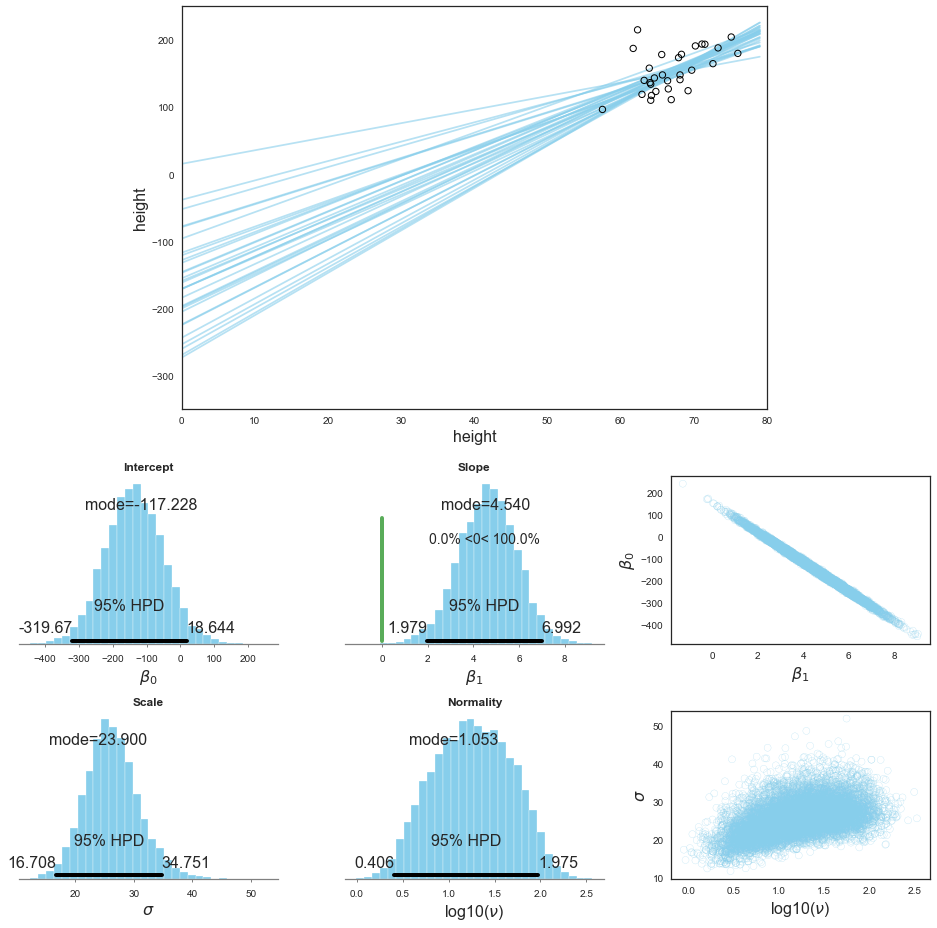

In [12]:
plot_grid(trace, 200, df_n30, sd_h, sd_w, mean_h, mean_w);

#### N = 300

In [13]:
df_n300 = pd.read_csv('data/HtWtData300.csv')
df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
male      300 non-null int64
height    300 non-null float64
weight    300 non-null float64
dtypes: float64(2), int64(1)
memory usage: 7.1 KB


In [14]:
sd_h2 = df_n300.height.std()
mean_h2 = df_n300.height.mean()
zheight2 = (df_n300.height - mean_h2)/sd_h2

sd_w2 = df_n300.weight.std()
mean_w2 = df_n300.weight.mean()
zy2 = (df_n300.weight - mean_w2)/sd_w2

#### Model

In [15]:
with pm.Model() as model2:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight2.ravel()
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy2.ravel())    

In [16]:
with model2:
    trace2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 394.88:  76%|███████▌  | 151362/200000 [00:20<00:06, 7486.31it/s]
Convergence archived at 152000
Interrupted at 152,000 [76%]: Average Loss = 438.69
100%|██████████| 10500/10500 [00:13<00:00, 788.29it/s]


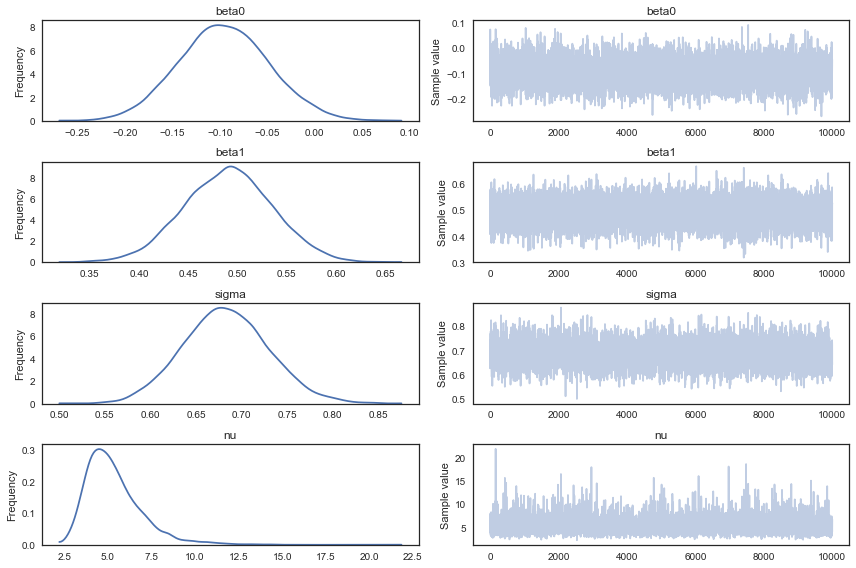

In [17]:
pm.traceplot(trace2);

#### Figure 17.4

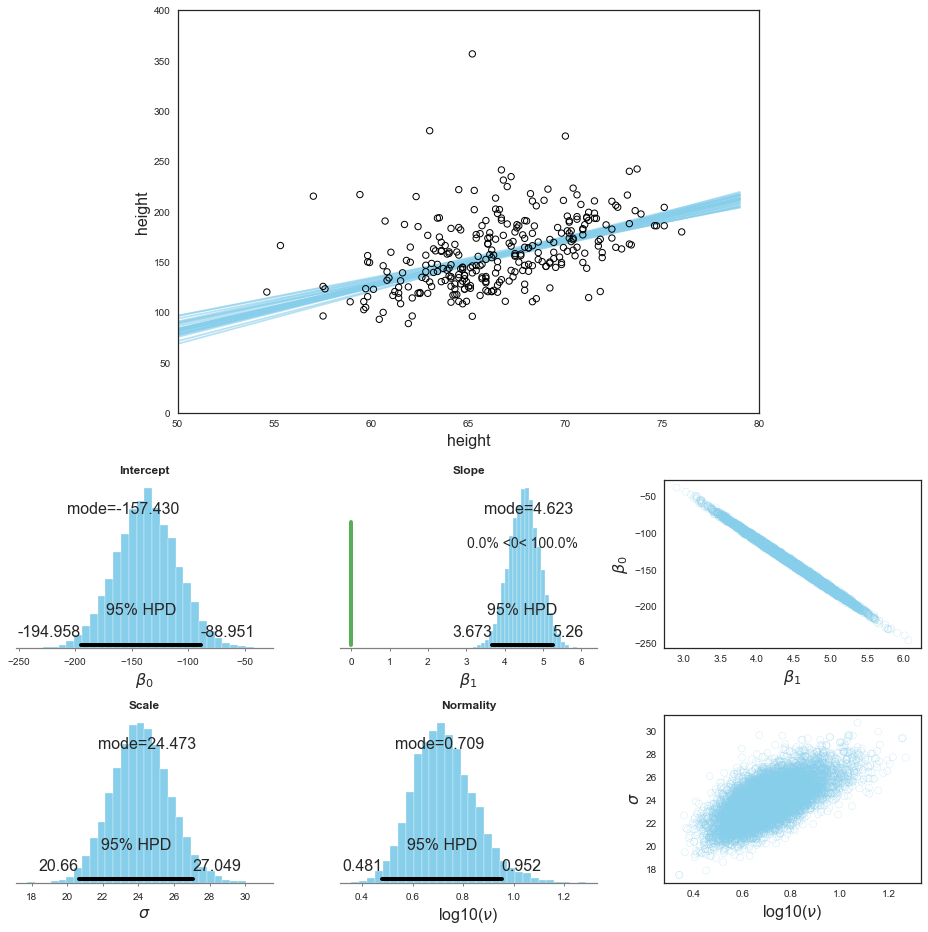

In [18]:
grid = plot_grid(trace2, 200, df_n300, sd_h2, sd_w2, mean_h2, mean_w2)
grid.axes[0].set_xlim(50,80)
grid.axes[0].set_ylim(0,400);

### 17.3 - Hierarchical Regression on Individuals within Groups

#### Model (Kruschke, 2015)

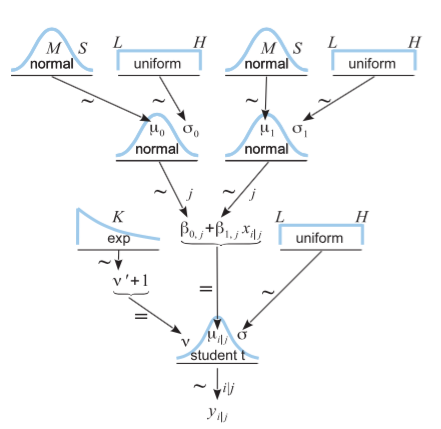

In [19]:
Image('images/fig17_6.png', width=500)

In [20]:
df_HRegr = pd.read_csv('data/HierLinRegressData.csv')
df_HRegr.Subj = df_HRegr.Subj.astype('category')
df_HRegr.Subj = df_HRegr.Subj.cat.as_ordered()
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Subj    132 non-null category
X       132 non-null float64
Y       132 non-null float64
dtypes: category(1), float64(2)
memory usage: 3.1 KB


In [21]:
df_HRegr.head()

,Subj,X,Y
0,1,60.2,145.6
1,1,61.5,157.3
2,1,61.7,165.6
3,1,62.3,158.8
4,1,67.6,196.1


In [22]:
subj_idx = df_HRegr.Subj.cat.codes.as_matrix()
subj_codes = df_HRegr.Subj.cat.categories
n_subj = len(subj_codes)

print('Number of groups: {}'.format(n_subj))

Number of groups: 25


In [23]:
sd_x = df_HRegr.X.std()
mean_x = df_HRegr.X.mean()
zx = (df_HRegr.X - mean_x)/sd_x

sd_y = df_HRegr.Y.std()
mean_y = df_HRegr.Y.mean()
zy = (df_HRegr.Y - mean_y)/sd_y

#### Model

In [24]:
with pm.Model() as model3:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    
    sigma0 = pm.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pm.Uniform('sigma1', 10**-3, 10**3)
    
    beta0_s = pm.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_subj)
    beta1_s = pm.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_subj)
    
    mu =  beta0_s[subj_idx] + beta1_s[subj_idx] * zx
    
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy)    

In [25]:
with model3:
    trace3 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 195.07: 100%|██████████| 200000/200000 [00:43<00:00, 4559.82it/s]
Finished [100%]: Average Loss = 195.07
100%|█████████▉| 10479/10500 [00:47<00:00, 215.24it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 10500/10500 [00:48<00:00, 218.68it/s]


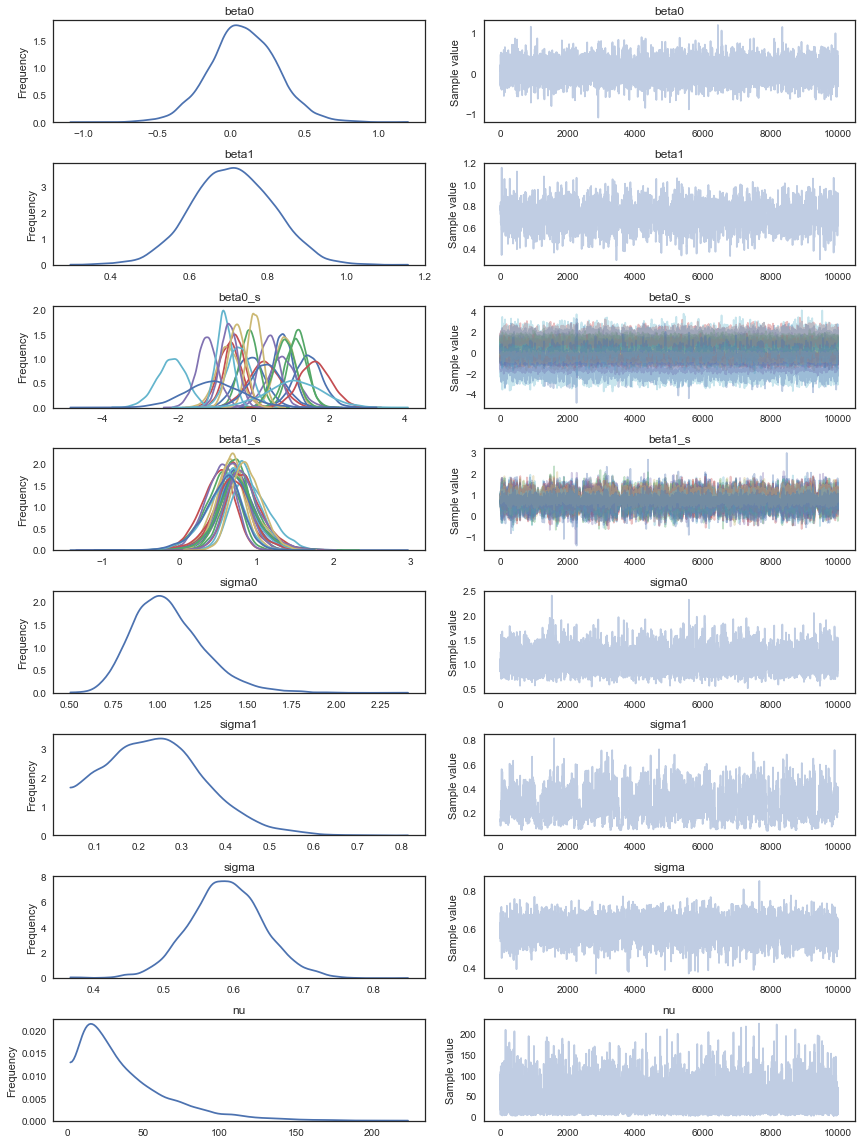

In [26]:
pm.traceplot(trace3);

#### Figure 17.5

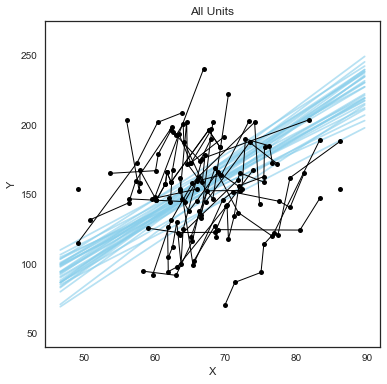

In [27]:
plt.figure(figsize=(6,6))
ax = plt.gca()

df_HRegr.groupby('Subj').apply(lambda group: ax.plot(group.X, group.Y, 'k-o', lw=1, markersize=5))
ax.set(xlabel='X', ylabel='Y', ylim=(40,275), title='All Units');

plot_cred_lines(np.c_[trace3['beta0'], trace3['beta1']], 100, df_HRegr.X, sd_x, sd_y, mean_x, mean_y, ax)

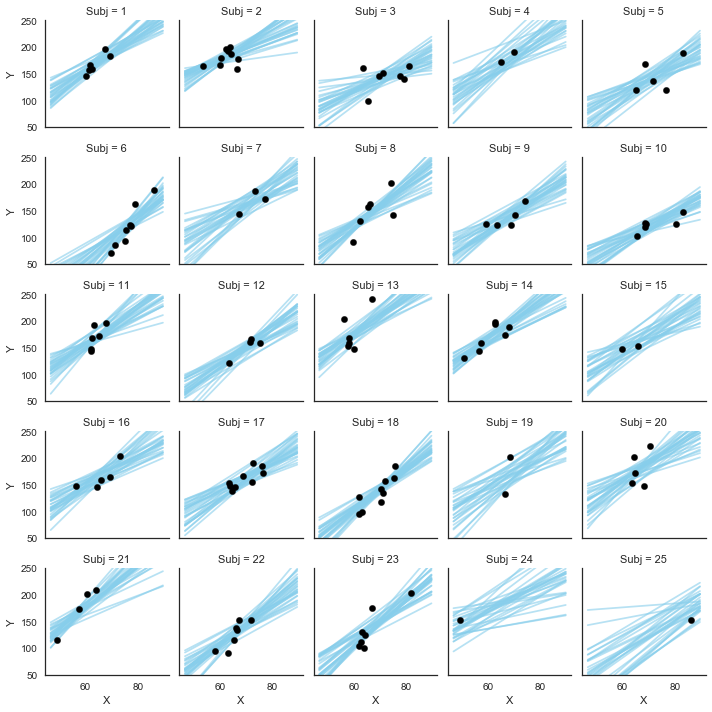

In [28]:
fg = sns.FacetGrid(df_HRegr, col='Subj', col_wrap=5, ylim=(50,250), size=2)
fg.map(plt.scatter, 'X', 'Y', color='k', s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(np.c_[trace3['beta0_s'][:,i], trace3['beta1_s'][:,i]],
                    100, df_HRegr.X, sd_x, sd_y, mean_x, mean_y, ax)

### 17.4 - Quadratic Trend and Weighted Data

In [29]:
df_income = pd.read_csv('data/IncomeFamszState3yr.csv', skiprows=1, dtype={'State':'category'})
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
FamilySize      312 non-null int64
State           312 non-null category
MedianIncome    312 non-null int64
SampErr         312 non-null int64
dtypes: category(1), int64(3)
memory usage: 10.6 KB


In [30]:
df_income.head()

,FamilySize,State,MedianIncome,SampErr
0,2,Alabama,48177,581
1,3,Alabama,53323,1177
2,4,Alabama,64899,1170
3,5,Alabama,59417,2446
4,6,Alabama,54099,3781


In [31]:
state_idx = df_income.State.cat.codes.as_matrix()
state_codes = df_income.State.cat.categories
n_states = len(state_codes)

print('Number of states: {}'.format(n_states))

Number of states: 52


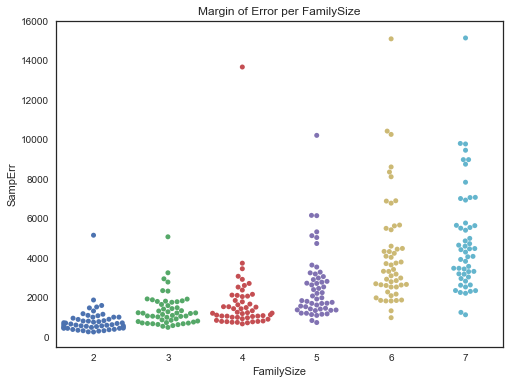

In [32]:
mean_fs = df_income.FamilySize.mean()
sd_fs = df_income.FamilySize.std()
z_fs = (df_income.FamilySize - mean_fs)/sd_fs

mean_income = df_income.MedianIncome.mean()
sd_income = df_income.MedianIncome.std()
z_income = (df_income.MedianIncome - mean_income)/sd_income

mean_error = df_income.SampErr.mean()
z_error = df_income.SampErr / mean_error

# There are fewer large-sized families than small-sized families, making the medians for income
# for the former group noisier. We can modulate the noise parameter with the margin of error. 
plt.figure(figsize=(8,6))
sns.swarmplot(x='FamilySize', y='SampErr', data=df_income)
plt.title('Margin of Error per FamilySize');

#### Model

In [33]:
with pm.Model() as model4:
       
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    beta2 = pm.Normal('beta2', mu=0, tau=1/10**2)
    
    sigma0 = pm.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pm.Uniform('sigma1', 10**-3, 10**3)
    sigma2 = pm.Uniform('sigma2', 10**-3, 10**3)
        
    beta0_s = pm.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_states)
    beta1_s = pm.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_states)
    beta2_s = pm.Normal('beta2_s', mu=beta2, sd=sigma2, shape=n_states)
    
    mu =  beta0_s[state_idx] + beta1_s[state_idx] * z_fs + beta2_s[state_idx] * z_fs**2
    
    nu = pm.Exponential('nu', 1/29.)
    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    
    # Modulate the noise parameter with the margin of error.
    w_sigma = tt.as_tensor(z_error)*sigma
        
    likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sd=w_sigma, observed=z_income)    

In [34]:
with model4:
    trace4 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 336.81: 100%|██████████| 200000/200000 [01:00<00:00, 3312.12it/s]
Finished [100%]: Average Loss = 336.85
100%|██████████| 10500/10500 [08:54<00:00, 20.47it/s]


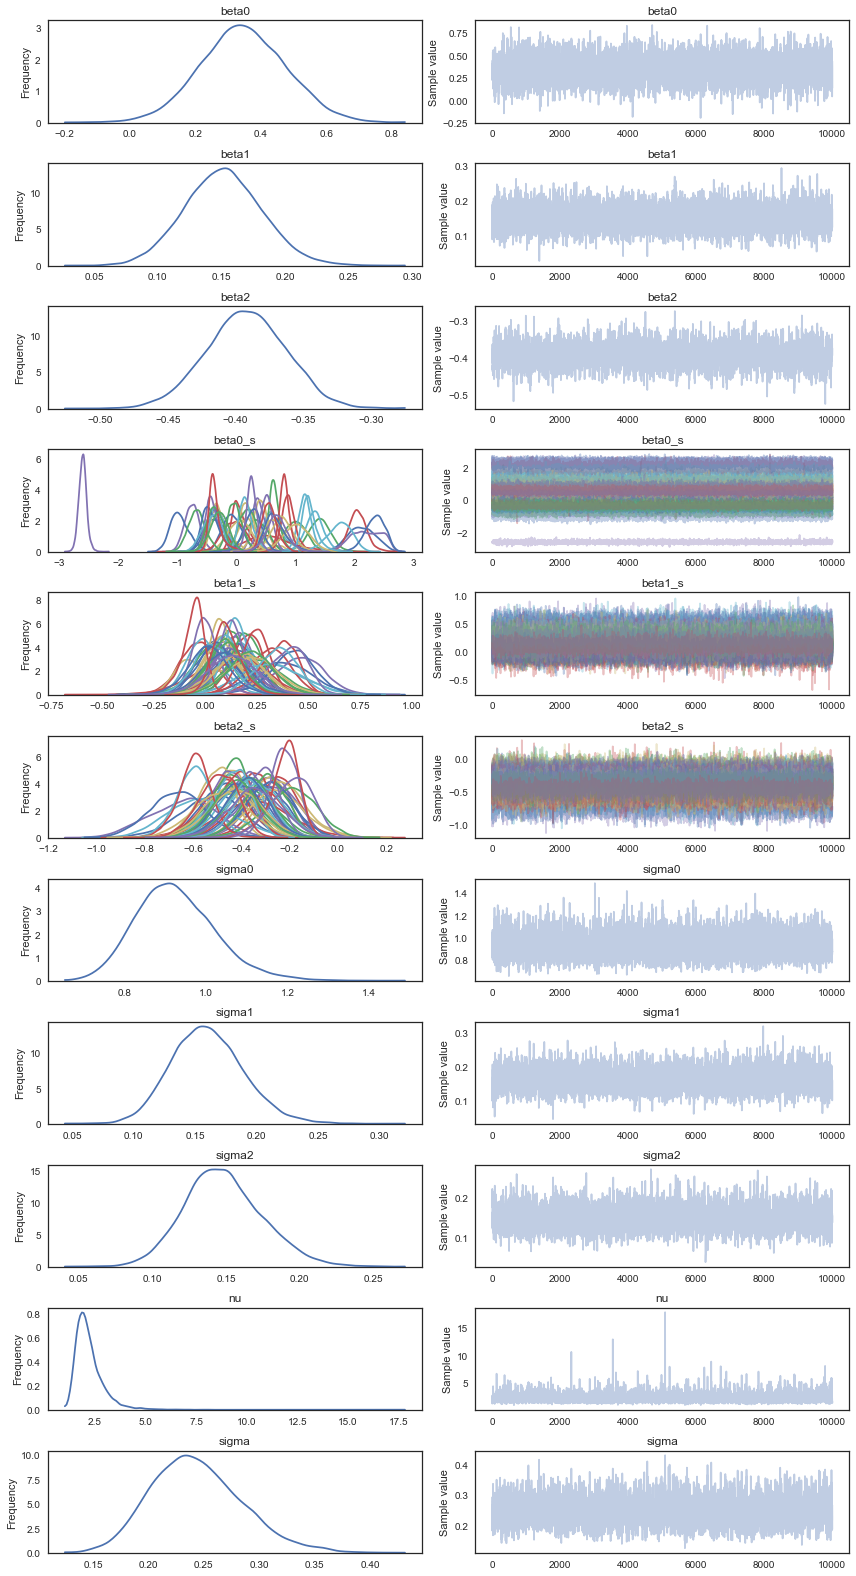

In [35]:
pm.traceplot(trace4);

#### Figure 17.7

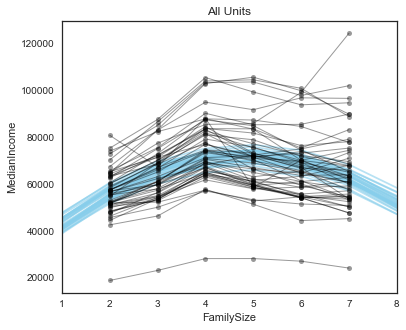

In [36]:
plt.figure(figsize=(6,5))
ax = plt.gca()

df_income.groupby('State').apply(lambda group: ax.plot(group.FamilySize,
                                                       group.MedianIncome,
                                                       'k-o', lw=1, markersize=5, alpha=.4))
ax.set(xlabel='FamilySize', ylabel='MedianIncome', xlim=(1,8), title='All Units');

plot_quad_credlines(np.c_[trace4['beta0'], trace4['beta1'], trace4['beta2']],
                    200, df_income.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)

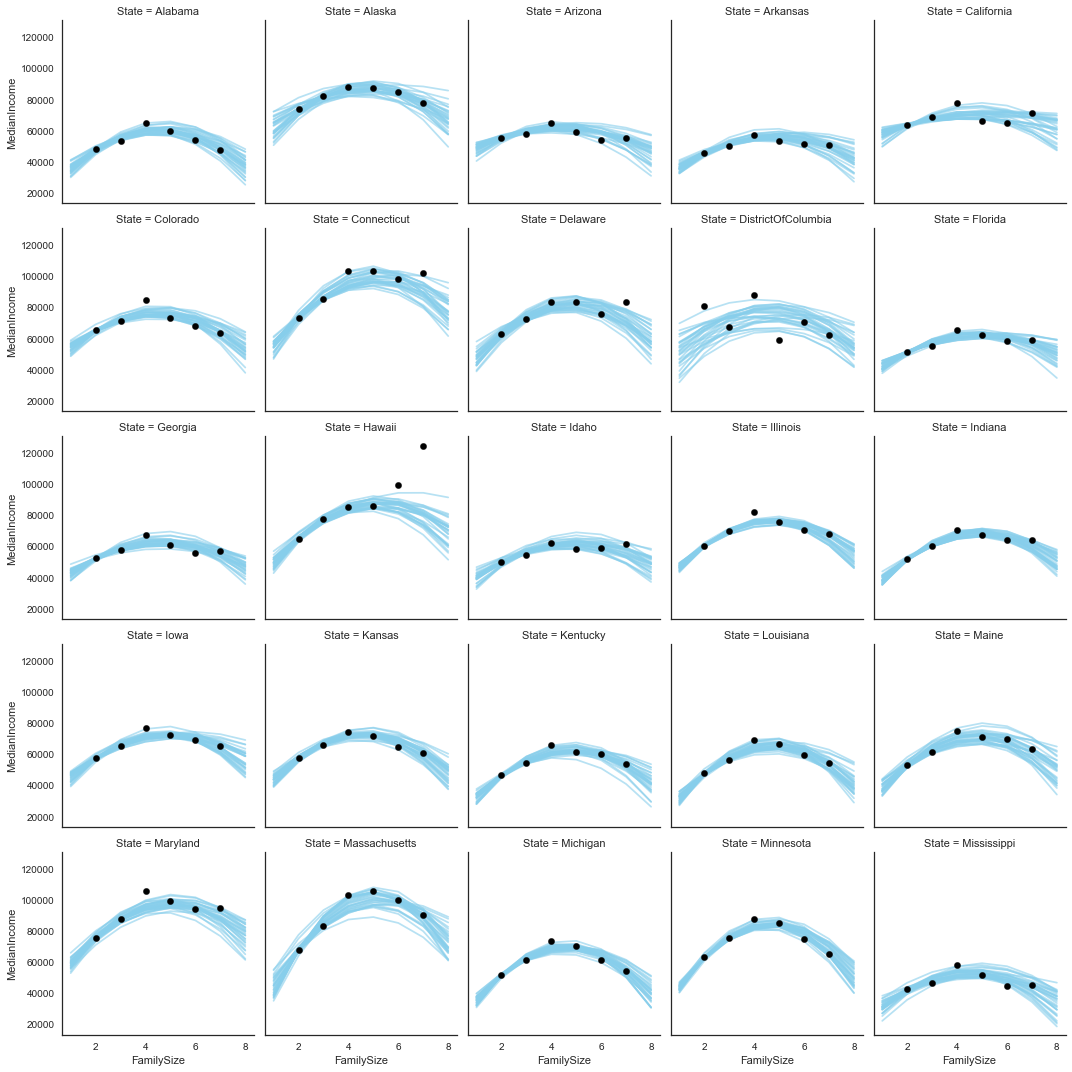

In [37]:
# The book shows the data for the first 25 States.
df_income_subset = df_income[df_income.State.isin(df_income.State.cat.categories[:25])]
df_income_subset.State.cat.remove_unused_categories(inplace=True)

fg = sns.FacetGrid(df_income_subset, col='State', col_wrap=5)
fg.map(plt.scatter, 'FamilySize', 'MedianIncome', color='k', s=40);

for i, ax in enumerate(fg.axes):
    plot_quad_credlines(np.c_[trace4['beta0_s'][:,i], trace4['beta1_s'][:,i], trace4['beta2_s'][:,i]],
                    200, df_income_subset.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)